In [46]:
import numpy as np
import torch
from sequitur.models import LSTM_AE
from sequitur import quick_train
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [47]:
open_seq_1 = np.load('../data/sequence/franka_cabinet_door_left_open.npy')
open_seq_2 = np.load('../data/sequence/franka_cabinet_door_right_open.npy')
open_seq_3 = np.load('../data/sequence/franka_cabinet_drawer_top_open.npy')

close_seq_1 = np.load('../data/sequence/franka_cabinet_door_left_close.npy')
close_seq_2 = np.load('../data/sequence/franka_cabinet_door_right_close.npy')
close_seq_3 = np.load('../data/sequence/franka_cabinet_drawer_top_close.npy')

In [48]:
open_len = open_seq_1.shape[0] + open_seq_2.shape[0] + open_seq_3.shape[0]
close_len = close_seq_1.shape[0] + close_seq_2.shape[0] + close_seq_3.shape[0]

Y = np.vstack([np.ones((open_len,1)), np.zeros((close_len,1))])
X = np.vstack([
    open_seq_1,
    open_seq_2,
    open_seq_3,
    close_seq_1,
    close_seq_2,
    close_seq_3
])

In [49]:
X.shape

(119386, 500, 11)

In [59]:
Y.shape

d = pd.DataFrame(Y)
d[d == 1].count()

0    4320
dtype: int64

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
data = [ torch.tensor(X_train[idx, :, 2:], dtype=torch.float32) for idx in range(X_train.shape[0])]

In [60]:
d = pd.DataFrame(y_test)
d[d == 1].count()

0    1447
dtype: int64

In [52]:
# Standard Library
from statistics import mean

# Third Party
import torch
from torch.nn import MSELoss


###########
# UTILITIES
###########


def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def instantiate_model(model, train_set, encoding_dim, **kwargs):
    if model.__name__ in ("LINEAR_AE", "LSTM_AE"):
        return model(train_set[-1].shape[-1], encoding_dim, **kwargs)
    elif model.__name__ == "CONV_LSTM_AE":
        if len(train_set[-1].shape) == 3:  # 2D elements
            return model(train_set[-1].shape[-2:], encoding_dim, **kwargs)
        elif len(train_set[-1].shape) == 4:  # 3D elements
            return model(train_set[-1].shape[-3:], encoding_dim, **kwargs)


def train_model(
    model, train_set, verbose, lr, epochs, denoise, clip_value, device=None
):
    if device is None:
        device = get_device()
        print(device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = MSELoss(reduction="sum")

    mean_losses = []
    for epoch in range(1, epochs + 1):
        model.train()

        # # Reduces learning rate every 50 epochs
        # if not epoch % 50:
        #     for param_group in optimizer.param_groups:
        #         param_group["lr"] = lr * (0.993 ** epoch)

        losses = []
        for x in tqdm(train_set):
            x = x.to(device)
            optimizer.zero_grad()

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()

            # Gradient clipping on norm
            if clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)

        if verbose:
            print(f"Epoch: {epoch}, Loss: {mean_loss}")

    return mean_losses


def get_encodings(model, train_set, device=None):
    if device is None:
        device = get_device()
    model.eval()
    encodings = [model.encoder(x.to(device)) for x in train_set]
    return encodings


######
# MAIN
######


def quick_train(
    model,
    train_set,
    encoding_dim,
    verbose=False,
    lr=1e-3,
    epochs=50,
    clip_value=1,
    denoise=False,
    device=None,
    **kwargs,
):
    model = instantiate_model(model, train_set, encoding_dim, **kwargs)
    losses = train_model(
        model, train_set, verbose, lr, epochs, denoise, clip_value, device
    )
    encodings = get_encodings(model, train_set, device)

    return model.encoder, model.decoder, encodings, losses

In [13]:
encoder, decoder, _, _ = quick_train(
    LSTM_AE, 
    data[: len(data) // 3],  
    verbose=True, 
    epochs=5, 
    lr=1e-3,

    encoding_dim=16,
    h_dims=[40, 32],
    h_activ=None,
    out_activ=None
)

cuda


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26662/26662 [02:57<00:00, 150.28it/s]


Epoch: 1, Loss: 809.150359564877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26662/26662 [02:58<00:00, 149.10it/s]


Epoch: 2, Loss: 803.5568610092552


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26662/26662 [02:59<00:00, 148.68it/s]


Epoch: 3, Loss: 802.8183122033538


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26662/26662 [02:45<00:00, 160.73it/s]


Epoch: 4, Loss: 801.8017168515049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26662/26662 [02:32<00:00, 174.61it/s]


Epoch: 5, Loss: 800.7085463346665


In [53]:
# torch.save(encoder.state_dict(), "../data/encoder_weights/5ep_1_3.pt")

model = LSTM_AE(
    input_dim=9,
    encoding_dim=16,
    h_dims=[40, 32],
    h_activ=None,
    out_activ=None
)
model.encoder.load_state_dict(torch.load("../data/encoder_weights/5ep_1_3.pt"))
encoder = model.encoder
encoder = encoder.to(get_device())

In [54]:
device = get_device()
input_data = torch.tensor(X_test[0, :, 2:], dtype=torch.float32).to(device)
encoder(input_data)

tensor([ 2.6861e-07,  7.0185e-07,  1.2550e-06, -2.7241e-08, -5.3619e-07,
         3.7289e-08,  2.7298e-07,  5.9299e-08, -3.7831e-07, -1.4061e-07,
        -5.4984e-07,  7.7527e-08, -1.2427e-07,  5.5694e-08, -1.3425e-06,
         4.3574e-08], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [55]:
points = [
    encoder(torch.tensor(X_test[idx, :, 2:], dtype=torch.float32).to(device)).detach().cpu().numpy() for idx in range(X_test.shape[0])
]
points = np.vstack(points)

In [56]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(points)

In [57]:
correct = 0
num_ones = 0
total = X_test.shape[0]
for idx in range(total):
    if kmeans.labels_[idx] == y_test[idx]:
        correct +=1

    if y_test[idx] == 1:
        num_ones += 1

In [58]:
num_ones

1447

In [32]:
correct/total * 100

96.3170719325854

In [33]:
np.save('../data/encoder_weights/test_embedding_points.npy', points)
# points = np.load('../data/encoder_weights/test_embedding_points.npy')

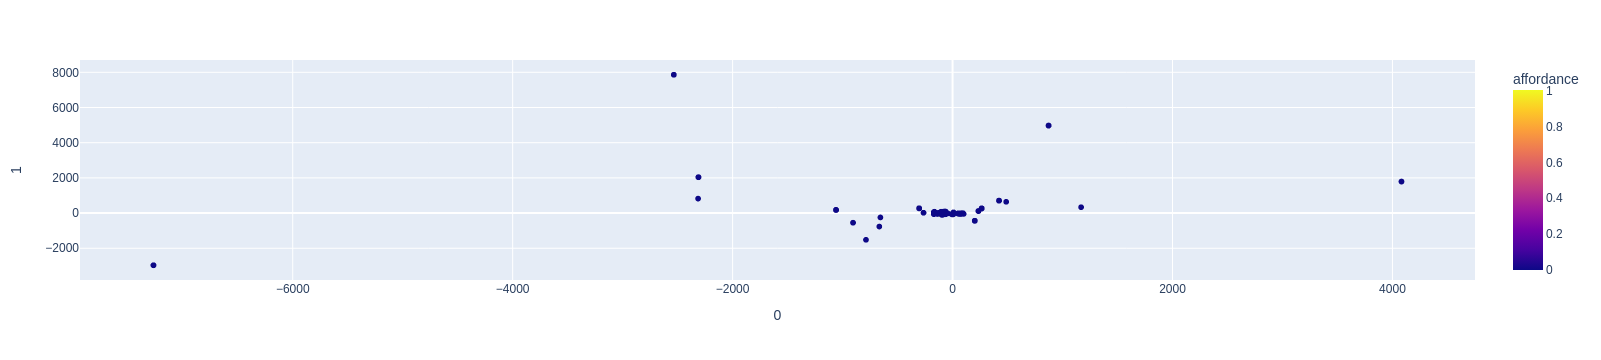

In [34]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(points)

fig = px.scatter(
    projections, x=0, y=1,
    color=kmeans.labels_, labels={'color': 'affordance'}
)
fig.update_layout(
    autosize=True,
    height=800,
)
fig.show()